In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.3.1
2.4.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

# EarlyStopping

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

save_best_model = ModelCheckpoint("wagi_best.h5",save_best_only=True)
lrate = LearningRateScheduler(step_decay)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, save_best_model, early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4200      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
943/943 [==============================] - 1s 2ms/step - loss: 0.3907 - accuracy: 0.8230 - val_loss: 0.3466 - val_accuracy: 0.8437
Epoch 2/100
943/943 [==============================] - 1s 1ms/step - loss: 0.3374 - accuracy: 0.8441 - val_lo

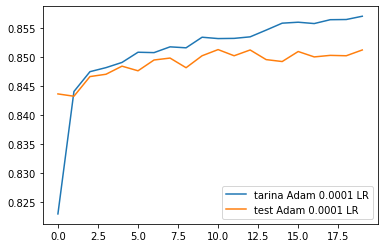

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam 0.0001 LR")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam 0.0001 LR")


plt.legend()
plt.show()

In [6]:
model.load_weights("wagi_best.h5")
model.evaluate(X_test,y_test)

471/471 [==============================] - 0s 765us/step - loss: 0.3174 - accuracy: 0.8501


[0.3174399435520172, 0.8500664234161377]

# Zad.
Do poniższych danych dobierz paametr
```python
patience=
```

Zwizualizuj wyniki dla obu modeli.

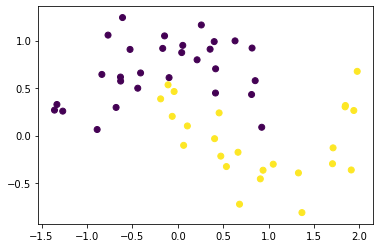

In [7]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [8]:
from tensorflow.keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_5 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_6 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 81ms/step - loss: 0.7805 - accuracy: 0.5472 - val_loss: 0.7540 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.6529 - accuracy: 0.5472 - val_

2/2 [==============================] - 0s 16ms/step - loss: 0.1901 - accuracy: 0.9057 - val_loss: 0.4892 - val_accuracy: 0.8085
Epoch 53/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1906 - accuracy: 0.9245 - val_loss: 0.4958 - val_accuracy: 0.8085
Epoch 54/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.1913 - accuracy: 0.9434 - val_loss: 0.4933 - val_accuracy: 0.8085
Epoch 55/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1907 - accuracy: 0.9245 - val_loss: 0.4652 - val_accuracy: 0.8298
Epoch 56/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1852 - accuracy: 0.9245 - val_loss: 0.4533 - val_accuracy: 0.8298
Epoch 57/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1852 - accuracy: 0.9245 - val_loss: 0.4516 - val_accuracy: 0.8298
Epoch 58/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1832 - accuracy: 0.9245 - val_loss: 0.4706 - val_accuracy: 0.8298
Epoch 59/1000
2/2 [=

Epoch 110/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0667 - accuracy: 0.9811 - val_loss: 0.2364 - val_accuracy: 0.9149
Epoch 111/1000
2/2 [==============================] - 0s 21ms/step - loss: 0.0654 - accuracy: 0.9811 - val_loss: 0.2286 - val_accuracy: 0.9149
Epoch 112/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0627 - accuracy: 0.9811 - val_loss: 0.2245 - val_accuracy: 0.9149
Epoch 113/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0618 - accuracy: 0.9811 - val_loss: 0.2138 - val_accuracy: 0.9149
Epoch 114/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0581 - accuracy: 1.0000 - val_loss: 0.1976 - val_accuracy: 0.8936
Epoch 115/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0574 - accuracy: 1.0000 - val_loss: 0.1897 - val_accuracy: 0.8936
Epoch 116/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0606 - accuracy: 1.0000 - val_loss: 0.1919 - val_accuracy: 0.8936

2/2 [==============================] - 0s 14ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.1841 - val_accuracy: 0.8936
Epoch 168/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.1874 - val_accuracy: 0.9149
Epoch 169/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.1959 - val_accuracy: 0.9362
Epoch 170/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.1928 - val_accuracy: 0.9362
Epoch 171/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.1864 - val_accuracy: 0.9149
Epoch 172/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.1833 - val_accuracy: 0.9149
Epoch 173/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0175 - accuracy: 1.0000 - val_loss: 0.1820 - val_accuracy: 0.8936
Epoch 174/1000

2/2 [==============================] - 0s 16ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.1973 - val_accuracy: 0.9149
Epoch 225/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1988 - val_accuracy: 0.9149
Epoch 226/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.2009 - val_accuracy: 0.8936
Epoch 227/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.2030 - val_accuracy: 0.8936
Epoch 228/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.2034 - val_accuracy: 0.9149
Epoch 229/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.1997 - val_accuracy: 0.9149
Epoch 230/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.1953 - val_accuracy: 0.9149
Epoch 231/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2113 - val_accuracy: 0.9149
Epoch 282/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.2110 - val_accuracy: 0.9149
Epoch 283/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.2118 - val_accuracy: 0.9149
Epoch 284/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.2125 - val_accuracy: 0.9149
Epoch 285/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.2138 - val_accuracy: 0.9149
Epoch 286/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2157 - val_accuracy: 0.9149
Epoch 287/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.2191 - val_accuracy: 0.9362
Epoch 288/1000

2/2 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2282 - val_accuracy: 0.9149
Epoch 339/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2280 - val_accuracy: 0.9149
Epoch 340/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2278 - val_accuracy: 0.9149
Epoch 341/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2285 - val_accuracy: 0.9149
Epoch 342/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2286 - val_accuracy: 0.9149
Epoch 343/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2276 - val_accuracy: 0.9149
Epoch 344/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2276 - val_accuracy: 0.9149
Epoch 345/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2430 - val_accuracy: 0.9149
Epoch 396/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2427 - val_accuracy: 0.9149
Epoch 397/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2429 - val_accuracy: 0.9149
Epoch 398/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2442 - val_accuracy: 0.9149
Epoch 399/1000
2/2 [==============================] - 0s 18ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2458 - val_accuracy: 0.9149
Epoch 400/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.2458 - val_accuracy: 0.9149
Epoch 401/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.2463 - val_accuracy: 0.9149
Epoch 402/1000

2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2591 - val_accuracy: 0.9149
Epoch 453/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2589 - val_accuracy: 0.9149
Epoch 454/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2596 - val_accuracy: 0.9149
Epoch 455/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2602 - val_accuracy: 0.9149
Epoch 456/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2605 - val_accuracy: 0.9149
Epoch 457/1000
2/2 [==============================] - 0s 17ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2607 - val_accuracy: 0.9149
Epoch 458/1000
2/2 [==============================] - ETA: 0s - loss: 1.4796e-04 - accuracy: 1.00 - 0s 19ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss

Epoch 509/1000
2/2 [==============================] - 0s 17ms/step - loss: 9.0766e-04 - accuracy: 1.0000 - val_loss: 0.2740 - val_accuracy: 0.9149
Epoch 510/1000
2/2 [==============================] - 0s 15ms/step - loss: 9.2386e-04 - accuracy: 1.0000 - val_loss: 0.2747 - val_accuracy: 0.9149
Epoch 511/1000
2/2 [==============================] - 0s 15ms/step - loss: 9.5831e-04 - accuracy: 1.0000 - val_loss: 0.2750 - val_accuracy: 0.9149
Epoch 512/1000
2/2 [==============================] - 0s 17ms/step - loss: 9.1949e-04 - accuracy: 1.0000 - val_loss: 0.2733 - val_accuracy: 0.9149
Epoch 513/1000
2/2 [==============================] - 0s 18ms/step - loss: 8.8717e-04 - accuracy: 1.0000 - val_loss: 0.2720 - val_accuracy: 0.9149
Epoch 514/1000
2/2 [==============================] - 0s 17ms/step - loss: 8.7747e-04 - accuracy: 1.0000 - val_loss: 0.2713 - val_accuracy: 0.9149
Epoch 515/1000
2/2 [==============================] - 0s 15ms/step - loss: 8.8841e-04 - accuracy: 1.0000 - val_loss: 0

2/2 [==============================] - 0s 15ms/step - loss: 6.9679e-04 - accuracy: 1.0000 - val_loss: 0.2817 - val_accuracy: 0.9149
Epoch 565/1000
2/2 [==============================] - 0s 14ms/step - loss: 6.8088e-04 - accuracy: 1.0000 - val_loss: 0.2830 - val_accuracy: 0.9149
Epoch 566/1000
2/2 [==============================] - 0s 13ms/step - loss: 7.0928e-04 - accuracy: 1.0000 - val_loss: 0.2842 - val_accuracy: 0.9149
Epoch 567/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.9975e-04 - accuracy: 1.0000 - val_loss: 0.2837 - val_accuracy: 0.9149
Epoch 568/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.8949e-04 - accuracy: 1.0000 - val_loss: 0.2838 - val_accuracy: 0.9149
Epoch 569/1000
2/2 [==============================] - 0s 13ms/step - loss: 6.9638e-04 - accuracy: 1.0000 - val_loss: 0.2845 - val_accuracy: 0.9149
Epoch 570/1000
2/2 [==============================] - 0s 15ms/step - loss: 6.7731e-04 - accuracy: 1.0000 - val_loss: 0.2842 - val_acc

Epoch 620/1000
2/2 [==============================] - 0s 20ms/step - loss: 5.4809e-04 - accuracy: 1.0000 - val_loss: 0.2938 - val_accuracy: 0.9149
Epoch 621/1000
2/2 [==============================] - 0s 17ms/step - loss: 5.4217e-04 - accuracy: 1.0000 - val_loss: 0.2934 - val_accuracy: 0.9149
Epoch 622/1000
2/2 [==============================] - 0s 14ms/step - loss: 5.4091e-04 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 0.9149
Epoch 623/1000
2/2 [==============================] - 0s 19ms/step - loss: 5.2823e-04 - accuracy: 1.0000 - val_loss: 0.2941 - val_accuracy: 0.9149
Epoch 624/1000
2/2 [==============================] - 0s 15ms/step - loss: 5.2117e-04 - accuracy: 1.0000 - val_loss: 0.2928 - val_accuracy: 0.9149
Epoch 625/1000
2/2 [==============================] - 0s 13ms/step - loss: 5.2191e-04 - accuracy: 1.0000 - val_loss: 0.2923 - val_accuracy: 0.9149
Epoch 626/1000
2/2 [==============================] - 0s 17ms/step - loss: 5.2374e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 676/1000
2/2 [==============================] - 0s 15ms/step - loss: 4.2449e-04 - accuracy: 1.0000 - val_loss: 0.3029 - val_accuracy: 0.9149
Epoch 677/1000
2/2 [==============================] - 0s 16ms/step - loss: 4.2258e-04 - accuracy: 1.0000 - val_loss: 0.3053 - val_accuracy: 0.9149
Epoch 678/1000
2/2 [==============================] - 0s 20ms/step - loss: 4.2065e-04 - accuracy: 1.0000 - val_loss: 0.3069 - val_accuracy: 0.9149
Epoch 679/1000
2/2 [==============================] - 0s 18ms/step - loss: 4.2613e-04 - accuracy: 1.0000 - val_loss: 0.3084 - val_accuracy: 0.9149
Epoch 680/1000
2/2 [==============================] - 0s 17ms/step - loss: 4.3222e-04 - accuracy: 1.0000 - val_loss: 0.3090 - val_accuracy: 0.9149
Epoch 681/1000
2/2 [==============================] - 0s 18ms/step - loss: 4.3263e-04 - accuracy: 1.0000 - val_loss: 0.3090 - val_accuracy: 0.9149
Epoch 682/1000
2/2 [==============================] - 0s 18ms/step - loss: 4.2500e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 732/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.4325e-04 - accuracy: 1.0000 - val_loss: 0.3117 - val_accuracy: 0.9149
Epoch 733/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.4138e-04 - accuracy: 1.0000 - val_loss: 0.3131 - val_accuracy: 0.9149
Epoch 734/1000
2/2 [==============================] - 0s 16ms/step - loss: 3.4948e-04 - accuracy: 1.0000 - val_loss: 0.3145 - val_accuracy: 0.9149
Epoch 735/1000
2/2 [==============================] - 0s 17ms/step - loss: 3.3895e-04 - accuracy: 1.0000 - val_loss: 0.3144 - val_accuracy: 0.9149
Epoch 736/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.3734e-04 - accuracy: 1.0000 - val_loss: 0.3142 - val_accuracy: 0.9149
Epoch 737/1000
2/2 [==============================] - 0s 15ms/step - loss: 3.3923e-04 - accuracy: 1.0000 - val_loss: 0.3143 - val_accuracy: 0.9149
Epoch 738/1000
2/2 [==============================] - 0s 17ms/step - loss: 3.4473e-04 - accuracy: 1.0000 - val_loss: 0

Epoch 788/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.9186e-04 - accuracy: 1.0000 - val_loss: 0.3229 - val_accuracy: 0.9149
Epoch 789/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.8717e-04 - accuracy: 1.0000 - val_loss: 0.3227 - val_accuracy: 0.9149
Epoch 790/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.8128e-04 - accuracy: 1.0000 - val_loss: 0.3232 - val_accuracy: 0.9149
Epoch 791/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.8587e-04 - accuracy: 1.0000 - val_loss: 0.3237 - val_accuracy: 0.9149
Epoch 792/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.8717e-04 - accuracy: 1.0000 - val_loss: 0.3229 - val_accuracy: 0.9149
Epoch 793/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.8199e-04 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9149
Epoch 794/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.8496e-04 - accuracy: 1.0000 - val_loss: 0

2/2 [==============================] - 0s 16ms/step - loss: 2.4271e-04 - accuracy: 1.0000 - val_loss: 0.3335 - val_accuracy: 0.9149
Epoch 844/1000
2/2 [==============================] - 0s 18ms/step - loss: 2.4010e-04 - accuracy: 1.0000 - val_loss: 0.3335 - val_accuracy: 0.9149
Epoch 845/1000
2/2 [==============================] - 0s 20ms/step - loss: 2.3740e-04 - accuracy: 1.0000 - val_loss: 0.3340 - val_accuracy: 0.9149
Epoch 846/1000
2/2 [==============================] - 0s 17ms/step - loss: 2.3740e-04 - accuracy: 1.0000 - val_loss: 0.3341 - val_accuracy: 0.9149
Epoch 847/1000
2/2 [==============================] - 0s 19ms/step - loss: 2.3655e-04 - accuracy: 1.0000 - val_loss: 0.3341 - val_accuracy: 0.9149
Epoch 848/1000
2/2 [==============================] - 0s 15ms/step - loss: 2.3524e-04 - accuracy: 1.0000 - val_loss: 0.3337 - val_accuracy: 0.9149
Epoch 849/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.3968e-04 - accuracy: 1.0000 - val_loss: 0.3329 - val_acc

Epoch 899/1000
2/2 [==============================] - 0s 16ms/step - loss: 2.0106e-04 - accuracy: 1.0000 - val_loss: 0.3406 - val_accuracy: 0.9149
Epoch 900/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.0239e-04 - accuracy: 1.0000 - val_loss: 0.3408 - val_accuracy: 0.9149
Epoch 901/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.0003e-04 - accuracy: 1.0000 - val_loss: 0.3414 - val_accuracy: 0.9149
Epoch 902/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.0129e-04 - accuracy: 1.0000 - val_loss: 0.3417 - val_accuracy: 0.9149
Epoch 903/1000
2/2 [==============================] - 0s 13ms/step - loss: 2.0456e-04 - accuracy: 1.0000 - val_loss: 0.3426 - val_accuracy: 0.9149
Epoch 904/1000
2/2 [==============================] - 0s 14ms/step - loss: 2.0152e-04 - accuracy: 1.0000 - val_loss: 0.3424 - val_accuracy: 0.9149
Epoch 905/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.9783e-04 - accuracy: 1.0000 - val_loss: 0

2/2 [==============================] - 0s 12ms/step - loss: 1.7460e-04 - accuracy: 1.0000 - val_loss: 0.3476 - val_accuracy: 0.9149
Epoch 955/1000
2/2 [==============================] - ETA: 0s - loss: 2.7816e-04 - accuracy: 1.00 - 0s 14ms/step - loss: 1.7221e-04 - accuracy: 1.0000 - val_loss: 0.3467 - val_accuracy: 0.9149
Epoch 956/1000
2/2 [==============================] - 0s 15ms/step - loss: 1.7125e-04 - accuracy: 1.0000 - val_loss: 0.3461 - val_accuracy: 0.9149
Epoch 957/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.7478e-04 - accuracy: 1.0000 - val_loss: 0.3455 - val_accuracy: 0.9149
Epoch 958/1000
2/2 [==============================] - 0s 14ms/step - loss: 1.7263e-04 - accuracy: 1.0000 - val_loss: 0.3457 - val_accuracy: 0.9149
Epoch 959/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.7433e-04 - accuracy: 1.0000 - val_loss: 0.3469 - val_accuracy: 0.9149
Epoch 960/1000
2/2 [==============================] - 0s 13ms/step - loss: 1.7234e-04 -

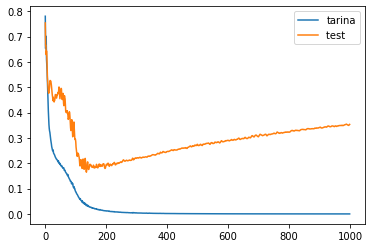

In [9]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

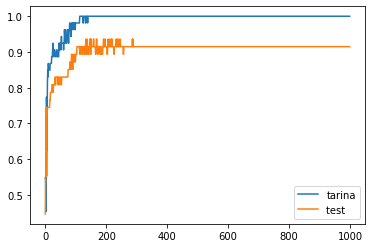

In [10]:
plt.plot(history_Adam.history['accuracy'], label = "tarina")
plt.plot(history_Adam.history['val_accuracy'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


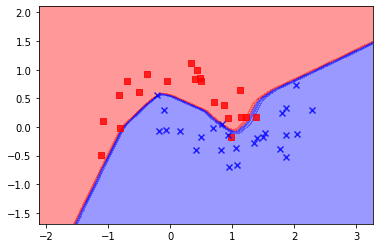

In [11]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Zad

Do powyższego modelu dodaj EarlyStopping:

```python
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)
```

In [12]:
from tensorflow.keras.callbacks import History


history_Adam_ES = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[early_stopping,history_Adam_ES])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_9 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_10 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.9228 - accuracy: 0.4528 - val_loss: 0.7399 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.7093 - accuracy: 0.5472 - val_

2/2 [==============================] - 0s 17ms/step - loss: 0.2007 - accuracy: 0.9245 - val_loss: 0.4876 - val_accuracy: 0.8085
Epoch 53/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.2020 - accuracy: 0.9245 - val_loss: 0.4828 - val_accuracy: 0.8085
Epoch 54/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1999 - accuracy: 0.9245 - val_loss: 0.4561 - val_accuracy: 0.8298
Epoch 55/1000
2/2 [==============================] - 0s 12ms/step - loss: 0.1952 - accuracy: 0.9245 - val_loss: 0.4463 - val_accuracy: 0.8298
Epoch 56/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.1940 - accuracy: 0.9057 - val_loss: 0.4508 - val_accuracy: 0.8298
Epoch 57/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.1910 - accuracy: 0.9057 - val_loss: 0.4537 - val_accuracy: 0.8298
Epoch 58/1000
2/2 [==============================] - 0s 11ms/step - loss: 0.1899 - accuracy: 0.9245 - val_loss: 0.4606 - val_accuracy: 0.8298
Epoch 59/1000
2/2 [=

Epoch 110/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0739 - accuracy: 0.9811 - val_loss: 0.2409 - val_accuracy: 0.8936
Epoch 111/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0739 - accuracy: 0.9811 - val_loss: 0.2412 - val_accuracy: 0.8936
Epoch 112/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0710 - accuracy: 0.9811 - val_loss: 0.2325 - val_accuracy: 0.8936
Epoch 113/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0684 - accuracy: 0.9811 - val_loss: 0.2320 - val_accuracy: 0.8936
Epoch 114/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0661 - accuracy: 0.9811 - val_loss: 0.2323 - val_accuracy: 0.9149
Epoch 115/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0649 - accuracy: 0.9811 - val_loss: 0.2354 - val_accuracy: 0.9149
Epoch 116/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0640 - accuracy: 0.9811 - val_loss: 0.2212 - val_accuracy: 0.9149

2/2 [==============================] - 0s 13ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 0.1835 - val_accuracy: 0.8936
Epoch 168/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.1851 - val_accuracy: 0.9149
Epoch 169/1000
2/2 [==============================] - 0s 13ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.1827 - val_accuracy: 0.8936
Epoch 170/1000
2/2 [==============================] - 0s 14ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.1793 - val_accuracy: 0.8936
Epoch 171/1000
2/2 [==============================] - 0s 15ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 0.1817 - val_accuracy: 0.8936
Epoch 172/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 0.1826 - val_accuracy: 0.9362
Epoch 173/1000
2/2 [==============================] - 0s 16ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.1808 - val_accuracy: 0.9149
Epoch 174/1000

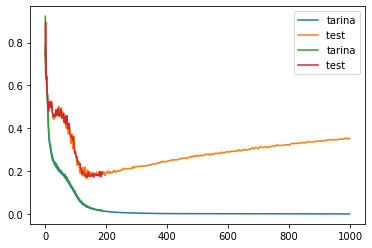

In [13]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")
plt.plot(history_Adam_ES.history['loss'], label = "tarina")
plt.plot(history_Adam_ES.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


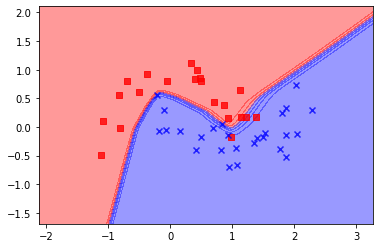

In [14]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()